# Travel Insurance
??
***

In [216]:
import sketch

## Business Problem Understanding
***

##### **Background**

Travel insurance is an insurance product for covering any losses while traveling, such as flight delay, loss luggage, trip cancellation, and more. Travel insurance companies offer various plans based on type of losses that can be claimed. In this problem, a travel insurance company aims to predict whether a policyholder will file a claim. This insight helps the company focus on groups less likely to file claims, thereby maximizing profits.

Target feature:     
0&emsp;:&ensp;Won't submit an insurance claim       
1&emsp;&nbsp;:&ensp;Will submit an insurance claim

##### **Problem Statement**

##### **Goals**

This company aims to predict whether policyholder will file a claim

Also the variables that 

pengen tahu siapa yang bakal file a claim, 

faktor apa aja yang bikin orang itu bakal claim, jadi bisa membuat strategi untuk memaksimalkan profitnya

##### **Metric Evaluation**

## Data Understanding
***

##### **Import libraries**

In [253]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, KBinsDiscretizer, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.decomposition import PCA

# Model Selection
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

##### **Attribute Information**

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | Text | Name of agency |
| Agency Type | Text | Type of travel insurance agencies |
| Distribution Channel | Text | Channel of travel insurance agencies |
| Product Name | Text | Name of travel insurance products |
| Gender | Text | Gender of insured |
| Duration | Integer | Duration of travel |
| Destination | Text | Destination of travel |
| Net Sales | Float | Amount of travel insurance policies |
| Commission (in value) | Float | Commission received for travel insurance agency |
| Age | Integer | Age of insured |
| Claim | Text | Claim status |

##### **Import dataset**

In [218]:
df = pd.read_csv('./data_travel_insurance.csv')

display(df.head(), df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


##### **Dataset Information**

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


## Data Cleaning
***

In [220]:
cleaned_df = df.copy()

display(cleaned_df.describe(include='object'), cleaned_df.describe(include='number'))

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


##### **Duplicate Values**

In [221]:
df_shape = df.shape
duplicated_values_count = cleaned_df.duplicated().sum()

display(f"Original data shape: {df_shape}",
    f"Duplicated values count: {duplicated_values_count}",
    f"Percentage of duplicated values: { duplicated_values_count / df_shape[0] * 100 }%")

'Original data shape: (44328, 11)'

'Duplicated values count: 4667'

'Percentage of duplicated values: 10.528334235697526%'

In [222]:
'''
Even though the duplicated value counts seems big, these data only represents 10% of the original data.
So it is better to drop whole duplicated values than to disrupt the ML accuracy.
'''

cleaned_df.drop_duplicates(inplace=True)

print(f"Cleaned data shape after removing duplicates: {cleaned_df.shape}")

Cleaned data shape after removing duplicates: (39661, 11)


##### **Missing Values**

In [223]:
missingVal = cleaned_df.isna().sum()
missingVal[missingVal > 0]

Gender    27667
dtype: int64

In [224]:
print(f"Percentage of missing values: { cleaned_df['Gender'].isna().sum() / cleaned_df.shape[0] * 100}%")

Percentage of missing values: 69.75870502508762%


In [225]:
'''
Given the high percentage of missing values in Gender column, it is reasonable to drop this column entirely.
In the context of travel claims, it is assumed that gender is unlikely to influence whether a claim is filed, as travel losses are typically caused by external factors such as natural disaster, or other.
'''

cleaned_df.drop(columns='Gender', axis=1, inplace=True)

##### **Numerical Outliers**

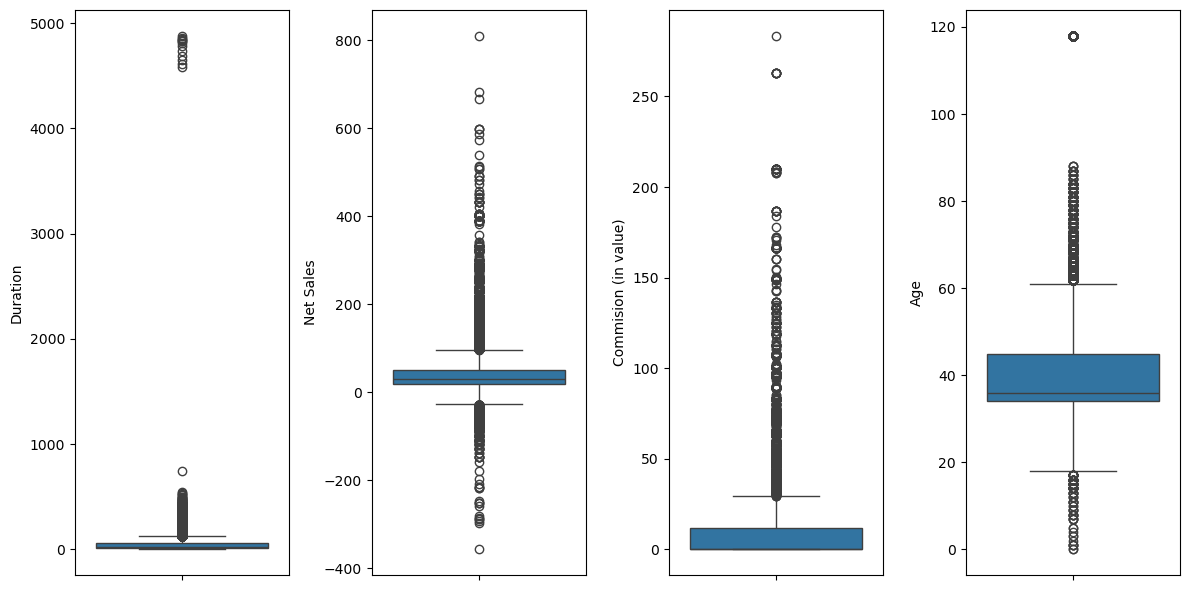

In [226]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [227]:
'''
Remove global / extreme outliers in numerical columns
'''

original_cleaned_df_shape = cleaned_df.shape

cleaned_df = cleaned_df[(cleaned_df['Duration'] < 600) & (cleaned_df['Net Sales'] <= 600) &
                        (cleaned_df['Net Sales'] >= 0) & (cleaned_df['Commision (in value)'] < 200) &
                        (cleaned_df['Age'] < 100) & (cleaned_df['Age'] > 0)]

display(f"Original cleaned df shape: { original_cleaned_df_shape }",
        f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }",
        f"Cleaned df shape aftering removing global outliers: { cleaned_df.shape[0] }",
        f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

'Original cleaned df shape: (39661, 10)'

'Number of removed values:  1002'

'Cleaned df shape aftering removing global outliers: 38659'

'Percentage of removed values: 2.5264113360732208%'

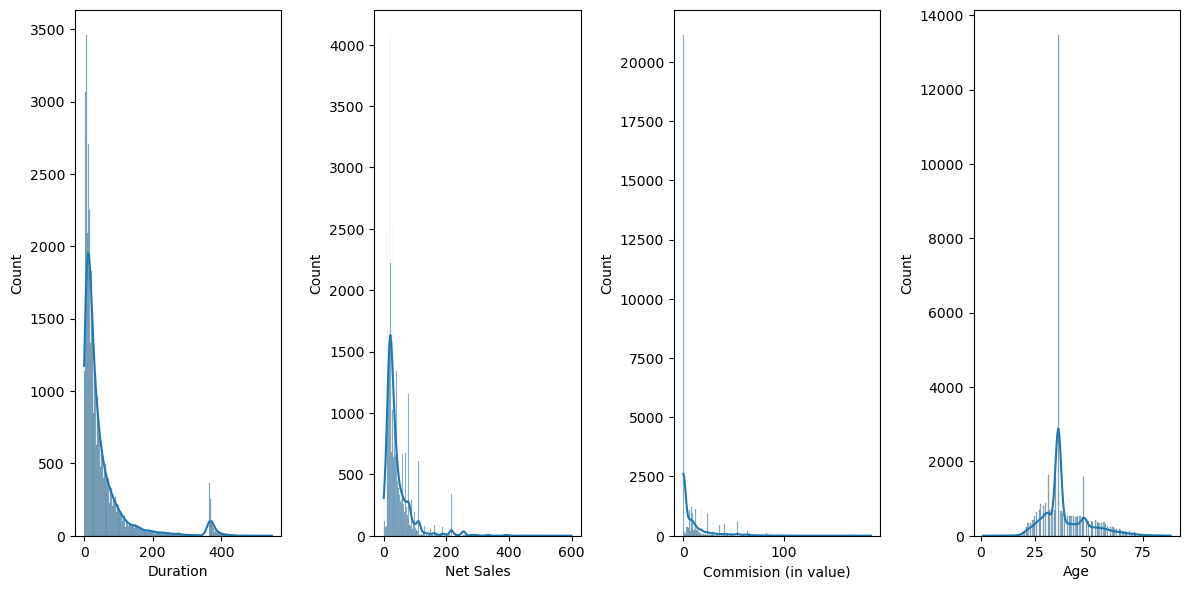

In [228]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.histplot(data=cleaned_df[column], kde=True)
plt.tight_layout()
plt.show()

##### **Categorical Outliers**

<function matplotlib.pyplot.show(close=None, block=None)>

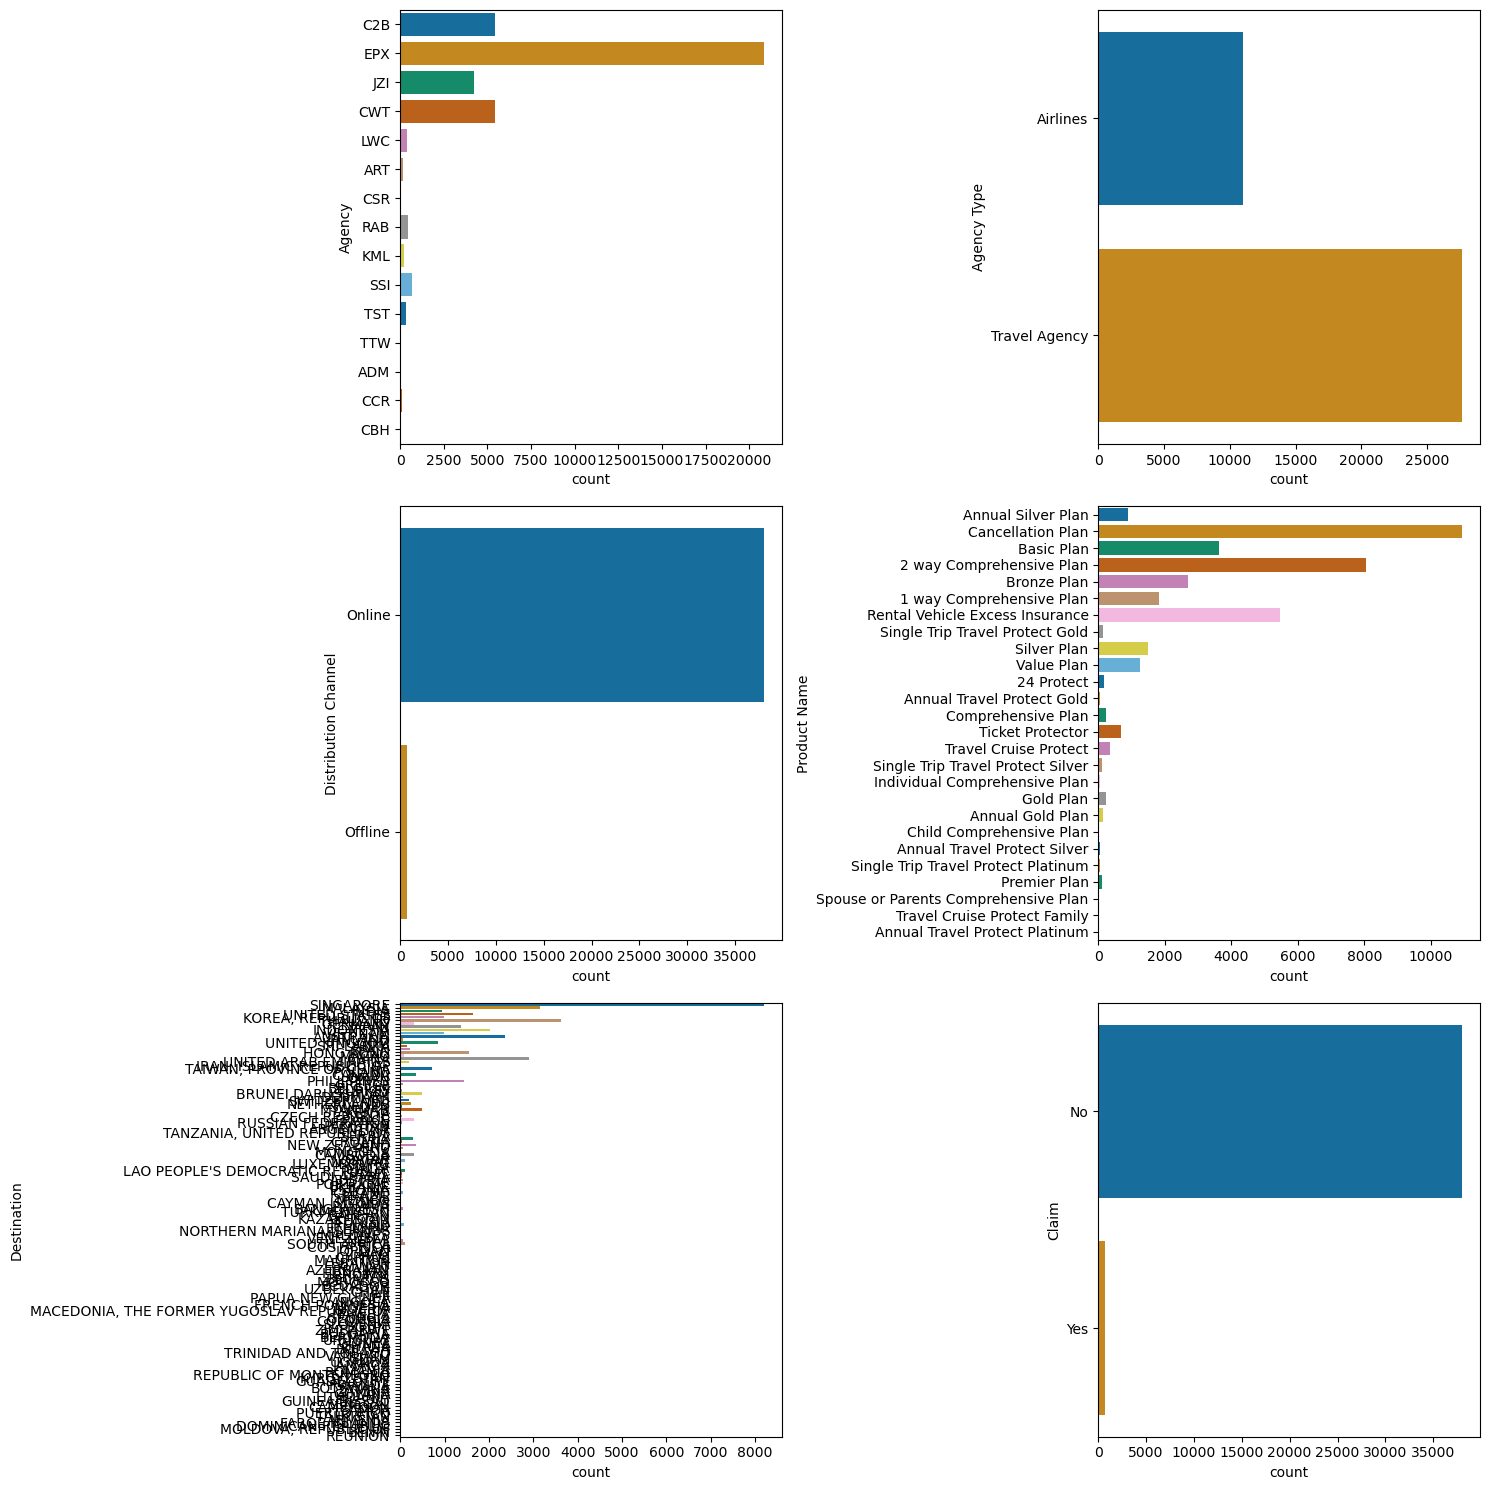

In [229]:
plt.figure(figsize=(15, 15))
for i, column in enumerate(cleaned_df.describe(include='object'), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=cleaned_df[column], palette='colorblind')
plt.tight_layout()
plt.show

## Feature Engineering
***

##### **Categorical Columns**

In [230]:
cleaned_df.describe(include='object')

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,38659,38659,38659,38659,38659,38659
unique,15,2,2,26,136,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,20828,27627,37991,10933,8190,37994


In [231]:
for column in cleaned_df.describe(include='object'):
    display(cleaned_df[column].value_counts().head())

Agency
EPX    20828
C2B     5461
CWT     5457
JZI     4223
SSI      691
Name: count, dtype: int64

Agency Type
Travel Agency    27627
Airlines         11032
Name: count, dtype: int64

Distribution Channel
Online     37991
Offline      668
Name: count, dtype: int64

Product Name
Cancellation Plan                  10933
2 way Comprehensive Plan            8058
Rental Vehicle Excess Insurance     5457
Basic Plan                          3641
Bronze Plan                         2707
Name: count, dtype: int64

Destination
SINGAPORE    8190
THAILAND     3633
MALAYSIA     3141
CHINA        2911
AUSTRALIA    2369
Name: count, dtype: int64

Claim
No     37994
Yes      665
Name: count, dtype: int64

In [232]:
'''
One hot encoding: Agency Type, Distribution Channel
Label encoding: Claim
Binary: Agency, Product Name, Destination

Ordinal encoding not used for any columns because there are no sequence
'''

categorical_transformer = [
    ('onehot', OneHotEncoder(drop='first'), ['Agency Type', 'Distribution Channel']),
    ('binary', ce.BinaryEncoder(), ['Agency', 'Product Name', 'Destination']),
]

##### **Numerical Columns**

In [233]:
cleaned_df.describe(include='number')

,Duration,Net Sales,Commision (in value),Age
count,38659.000000,38659.000000,38659.000000,38659.000000
mean,50.343413,43.131362,9.932944,38.976202
std,74.365848,47.533343,19.074776,10.474342
min,0.000000,0.000000,0.000000,1.000000
25%,10.000000,19.800000,0.000000,34.000000
50%,24.000000,29.000000,0.000000,36.000000
75%,56.000000,50.000000,11.750000,44.000000
max,547.000000,599.000000,186.710000,88.000000


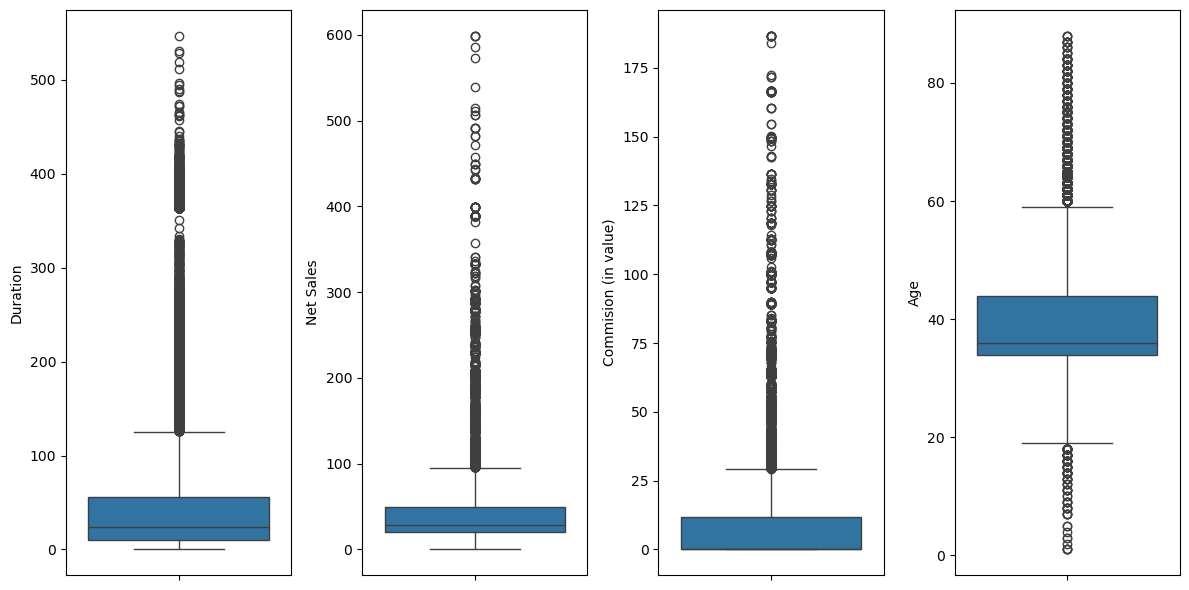

In [234]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [235]:
def commission_binning(X):
    return (X > 0).astype(int)

In [236]:
'''
Binning: Commission
-> Extremely skewed. Many zero values shown by Q1 and Q3

Robust Scaler: Net sales, Duration
-> Because these columns have big amount of outliers
'''

numerical_transformer = [
    ('robust', RobustScaler(), ['Net Sales', 'Duration']),
    ('binning', FunctionTransformer(commission_binning), ['Commision (in value)']),
]

##### **Data Split**

In [237]:
X = cleaned_df.drop(columns=['Claim'])
y = cleaned_df['Claim']

In [238]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

In [239]:
feature_engineering_transformer = ColumnTransformer(
    numerical_transformer + categorical_transformer,
    remainder='passthrough'
)

X_train_prep = feature_engineering_transformer.fit_transform(X_train)
X_test_prep = feature_engineering_transformer.transform(X_test)

In [240]:
columns_name = []

for i in range(5):
    if i == 1:
        columns_name += ['Commision (in value)']
        continue
    
    columns_name += list(feature_engineering_transformer.transformers_[i][1].get_feature_names_out())

X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

X_train_prep.columns = columns_name
X_test_prep.columns = columns_name

## Feature Selection
***

##### **PCA**

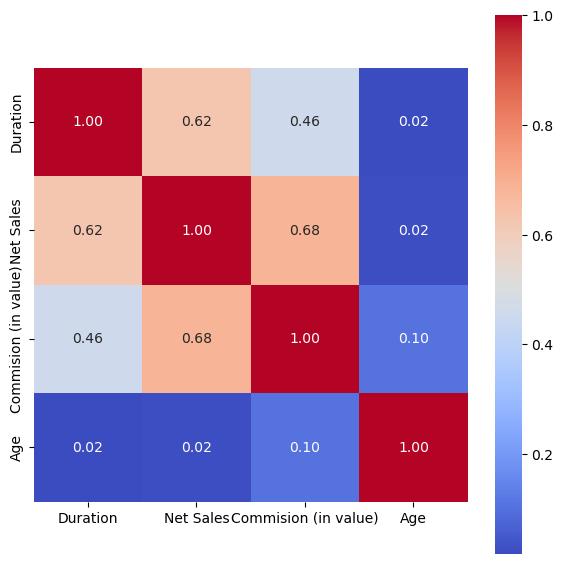

In [241]:
plt.figure(figsize=(7,7))
sns.heatmap(cleaned_df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.show()

In [242]:
'''
Reduce the dimension of numerical columns by performing PCA to features: Duration, Net Sales, Commission
-> Shown there are high correlation value between this features which represents multicollinearity
'''

pca_columns = X_train_prep[['Duration', 'Net Sales', 'Commision (in value)']]
non_pca_columns = X_train_prep.drop(columns=['Duration', 'Net Sales', 'Commision (in value)'])

pca_columns_test = X_test_prep[['Duration', 'Net Sales', 'Commision (in value)']]
non_pca_columns_test = X_test_prep.drop(columns=['Duration', 'Net Sales', 'Commision (in value)'])

pca = PCA(n_components=1)
pca_fit = pca.fit_transform(pca_columns)
pca_fit_test = pca.fit_transform(pca_columns_test)

pca_df = pd.DataFrame(pca_fit)
pca_df_test = pd.DataFrame(pca_fit_test)
pca_df.columns = ['PCA Feature']
pca_df_test.columns = ['PCA Feature']

In [243]:
display(f"Explained Variance Ratio: {pca.explained_variance_ratio_[0] * 100}%",
        f"Lost Variance While Compressing into One Dimension: {100 - pca.explained_variance_ratio_[0] * 100}%")

X_train_prep = pd.concat([non_pca_columns, pca_df], axis=1)
X_test_prep = pd.concat([non_pca_columns_test, pca_df_test], axis=1)

'Explained Variance Ratio: 77.964324641472%'

'Lost Variance While Compressing into One Dimension: 22.035675358527996%'

In [244]:
X_train_prep.shape

(30927, 21)

## Modeling
***

##### **Model Benchmark to Train Data**

In [245]:
algorithm_list = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

In [246]:
score_list_precision = []
mean_list_precision = []
std_list_precision = []

score_list_roc_auc = []
mean_list_roc_auc = []
std_list_roc_auc = []

for algorithm in algorithm_list:
    cv_score_precision = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = 5,
        scoring='precision'
    )
    
    cv_score_roc = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = 5,
        scoring='roc_auc'
    )
    
    score_list_precision.append(cv_score_precision)
    mean_list_precision.append(cv_score_precision.mean())
    std_list_precision.append(cv_score_precision.std())
    
    score_list_roc_auc.append(cv_score_roc)
    mean_list_roc_auc.append(cv_score_roc.mean())
    std_list_roc_auc.append(cv_score_roc.std())

In [247]:
'''
TP : Actual 1, Predicted 1
FP : Actual 0, Predicted 1 ( Type I Error )
TN : Actual 0, Predicted 0
FN : Actual 1, Predicted 0 ( Type II Error )

Precision is used because the company goal is to maximize its profit by focusing on groups that less likely file a claim.
Means to minimize the FP (False Positive)
'''

cv_score_df = pd.DataFrame()
cv_score_df['Model'] = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

cv_score_df['Mean Precision'] = mean_list_precision
cv_score_df['Mean ROC AUC'] = mean_list_roc_auc

cv_score_df['Standard Deviation Precision'] = std_list_precision
cv_score_df['Standard Deviation ROC AUC'] = std_list_roc_auc

cv_score_df = cv_score_df.set_index('Model')

cv_score_df.sort_values(by='Mean ROC AUC', ascending=False)

,Mean Precision,Mean ROC AUC,Standard Deviation Precision,Standard Deviation ROC AUC
Model,,,,
Logistic Regression,0.000000,0.797611,0.000000,0.028288
Random Forest,0.023709,0.652193,0.012321,0.004343
KNN,0.000000,0.575286,0.000000,0.015563
Decision Tree,0.053229,0.522098,0.012959,0.006240


Logistic Regression has the highest ROC AUC score meaning that it is the best algorithms so far even when the precision value is 0.       
0 value in the precision for this algorithm might happen because the dataset is imbalance.      

##### **Model Benchmark to Test Data**

In [248]:
fpr_score_list = []
tpr_score_list = []
auc_score_list = []
cm_list = []

for algorithm in algorithm_list:
    clf = algorithm.fit(X_train_prep, y_train)
    y_pred = clf.predict(X_test_prep)
    y_pred_proba = clf.predict_proba(X_test_prep)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    fpr_score_list.append(fpr)
    tpr_score_list.append(tpr)
    auc_score_list.append(auc)
    cm_list.append(cm)

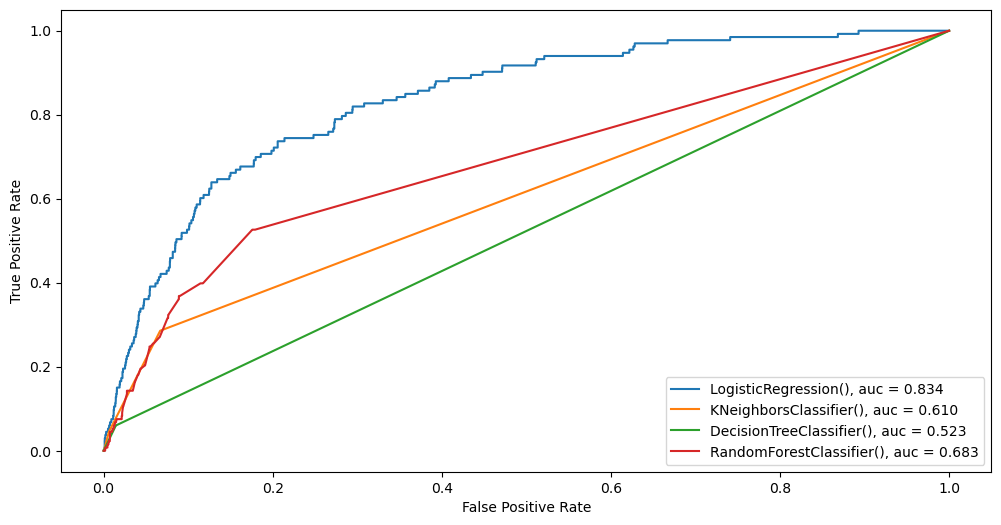

In [249]:
plt.figure(figsize=(12, 6))

for i in enumerate(algorithm_list):
    plt.plot(fpr_score_list[i[0]], tpr_score_list[i[0]], label=f"{i[1]}, auc = {auc_score_list[i[0]]:.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

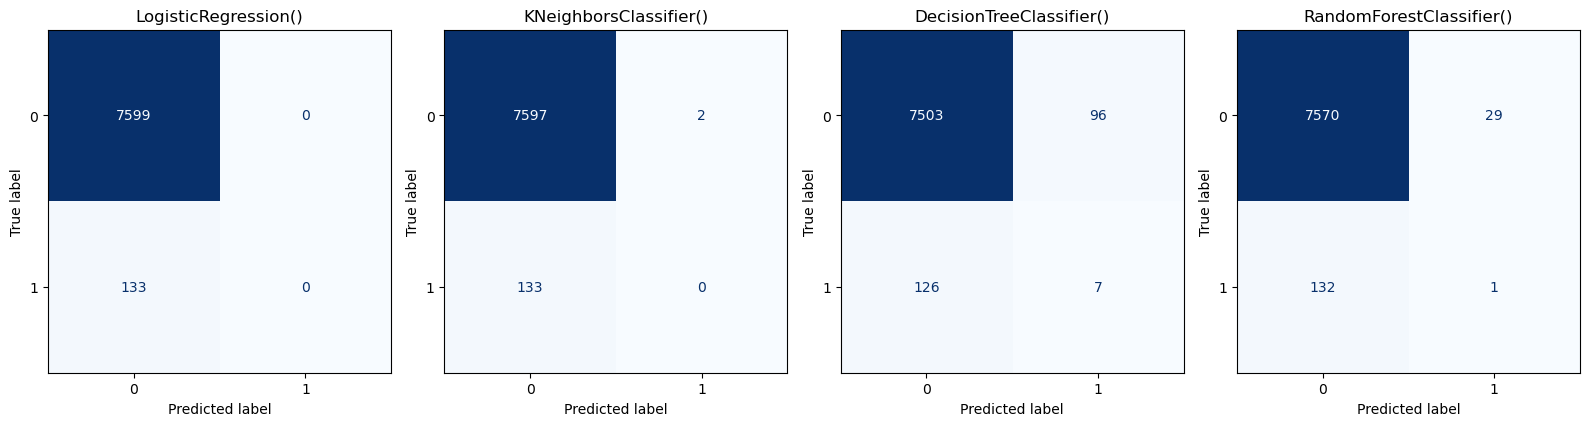

In [250]:
fig, axes = plt.subplots(1, len(cm_list), figsize=(len(cm_list) * 4, 4))

for i, (cm, ax) in enumerate(zip(cm_list, axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(algorithm_list[i])

plt.tight_layout()
plt.show()

Logistic Regression has the highest ROC AUC score again.        
But as shown in the Logistic Regression confusion matrix above, the TP (True 1, Predicted 1) is 0 which indicates this algorithm failed to predict customer that will file a claim.       

Meanwhile from these confusion matrixes, Decision Tree has the lowest number of FP (True 1, Predicted 0) which is the company main goal.

##### **Oversampling**

In [251]:
y_value_counts = np.unique(y, return_counts=True)

y_value_counts_df = pd.DataFrame()
y_value_counts_df["Target"] = y_value_counts[0]
y_value_counts_df["Count"] = y_value_counts[1]
y_value_counts_df["Percentage"] = [(y_value_counts[1][0]/len(y) * 100), (y_value_counts[1][1]/len(y) * 100)]

y_value_counts_df.set_index('Target')

,Count,Percentage
Target,,
0,37994,98.279831
1,665,1.720169


In [ ]:
knn = KNeighborsClassifier().fit(X_train_prep, y_train)
dt = DecisionTreeClassifier().fit(X_train_prep, y_train)
rf = RandomForestClassifier().fit(X_train_prep, y_train)
lg = LogisticRegression().fit(X_train_prep, y_train)

# Fungsi untuk mengevaluasi dan mengembalikan hasil sebagai kamus
def evaluate_model(model, X_test_prep, y_test):
    y_pred = model.predict(X_test_prep)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    results = {
        'Confusion Matrix': cm,
        'True Positive (TP)': tp,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Negative (TN)': tn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results
 
# Mengevaluasi setiap model dan mengumpulkan hasilnya
results = {
    'Logistic': evaluate_model(lg, X_test_prep, y_test),
    'K-Nearest Neighbors (KNN)': evaluate_model(knn, X_test_prep, y_test),
    'Decision Tree (DT)': evaluate_model(dt, X_test_prep, y_test),
    'Random Forest (RF)': evaluate_model(rf, X_test_prep, y_test),
}
 
# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
 
# Isi DataFrame dengan hasil
rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })
 
# Konversi daftar kamus ke DataFrame
summary_df = pd.DataFrame(rows)
 
# Tampilkan DataFrame


In [ ]:
summary_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic,0.982799,0.000000,0.000000,0.000000
1,K-Nearest Neighbors (KNN),0.982669,0.333333,0.007519,0.014706
3,Random Forest (RF),0.978272,0.073171,0.022556,0.034483
2,Decision Tree (DT),0.969089,0.079365,0.075188,0.077220


## Evaluation
***